# Pre-Requisites

Load neccesary packages/libraries and print versions for reference.

Notes:
- Reference: Python 3.12.7 - miniconda3
- Always use "Open folder" to open local repository
    - "Add folder" breaks the python version

In [14]:
# Packages and Libraries
import cellxgene_census
import tiledbsoma
import spatialdata as sd
import spatialdata_plot
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# Versions of required libraries
print("cellxgene_census",cellxgene_census.__version__)
print("tiledbsoma", tiledbsoma.__version__)
print("spatialdata", sd.__version__)
print("spatialdata plot", spatialdata_plot.__version__)

# Expand 'pandas' print limit to prevent early truncation of large dataframes
pd.set_option("display.max_colwidth", 100)

cellxgene_census 1.16.2
tiledbsoma 1.15.6
spatialdata 0.3.0
spatialdata plot 0.2.9


# Query CellxGene for 'dataset_id'

Use's chosen filters to find the wanted experiment based on tissue and disease to then poll the 'dataset_id' which is explicitly needed for the proceeding spatial analysis

In [ ]:
with cellxgene_census.open_soma(census_version="2025-01-30") as census:
    cell_metadata = census["census_spatial_sequencing"]["homo_sapiens"].obs.read(
        # Below are a some filtering options -- 'uncomment' only the one you want to use
        #value_filter = "tissue == 'labial gland' and disease == 'Sjogren syndrome'",
        value_filter = "tissue == 'labial gland' and disease == 'normal'",
        value_filter = "tissue == 'labial gland' and assay == 'Visium Spatial Gene Expression'",
        column_names = ["assay", "tissue", "tissue_general", "disease", "dataset_id"]
    )
    
    # Concatenates results to pyarrow.Table
    cell_metadata = cell_metadata.concat()

    # Converts to pandas.DataFrame
    cell_metadata = cell_metadata.to_pandas()

    print(cell_metadata)

# Prints all the unique dataset_ids
dataset_ids = cell_metadata['dataset_id'].unique()
# print(cell_metadata['dataset_id'].unique())
print(dataset_ids)

                                 assay        tissue  tissue_general  \
0       Visium Spatial Gene Expression  labial gland  exocrine gland   
1       Visium Spatial Gene Expression  labial gland  exocrine gland   
2       Visium Spatial Gene Expression  labial gland  exocrine gland   
3       Visium Spatial Gene Expression  labial gland  exocrine gland   
4       Visium Spatial Gene Expression  labial gland  exocrine gland   
...                                ...           ...             ...   
119803  Visium Spatial Gene Expression  labial gland  exocrine gland   
119804  Visium Spatial Gene Expression  labial gland  exocrine gland   
119805  Visium Spatial Gene Expression  labial gland  exocrine gland   
119806  Visium Spatial Gene Expression  labial gland  exocrine gland   
119807  Visium Spatial Gene Expression  labial gland  exocrine gland   

                 disease                            dataset_id  
0       Sjogren syndrome  00ba8341-48ec-4e4e-bb56-be0dd2dd7913  
1    

## Sjögerns Disease Spatial Dataset IDs
- 24 total spatial datasets in collection
- 11 Sjogren Syndrome Dataset IDs
- 13 Normal Dataset IDs
- **Bold indicates disease + immune system disorder**

|    | Sjogren Syndrome                         | Normal                                   |
|----|------------------------------------------|------------------------------------------|
| 1  | 00ba8341-48ec-4e4e-bb56-be0dd2dd7913     | 3a55b986-2517-4e4b-be24-9c676849fc60     |
| 2  | 36a9ccdd-f1a3-4f15-aaad-8eae728cd66c     | 4825ab17-d48f-4758-9fa8-2a291d7c7324     |
| 3  | 0819e386-e7fd-4212-b732-60e468689f89     | 53ff2250-4434-4f59-9fbb-1a474c21d9c0     |
| 4  | db5ddd64-6a42-4138-89e0-7448fc4fc923     | ec2ea7ec-92cf-4b48-ac5e-1bb6e6e26ef4     |
| 5  | 59a3e980-ac11-42b5-b2a8-b948509a2154     | dcc7c14c-1617-4d94-9253-6e73a344fcb0     |
| 6  | 953bfc7b-2004-4041-8b50-92c31a505bf7     | 2abc33b4-d8df-45b6-bc85-db78f067fe59     |
| 7  | 4b1a2706-7c40-4fe6-a422-be79603e0162     | 9fc34171-1273-44b3-8e16-6bea49dfd969     |
| 8  | d06dd93c-d4fc-49bd-8817-057f70680dca     | 5afc26df-9e84-4fc2-96a0-4ce4404af16b     |
| 9  | 194062ef-cdb9-4fb9-a00d-2478172fdc06     | b2130fdc-5a8b-456d-8d71-492d1a656d26     |
| 10 | 968c9b50-c7e2-40d6-8335-69a6802e06a8     | 980d342b-126d-4724-9e55-96cbcbb7d7fe     |
| 11 | **ad2f25f0-acc4-4c4e-b796-6c85f8821964** | **1218b9f0-4f95-47a0-b69a-847c92087ded** |
| 12 | _ _                                      | **e28f0c23-7922-4a18-85c5-b2201c06b681** |
| 13 | _ _                                      | **344f27ab-428c-4a0e-a7e1-d4441f2f9b80** |

# Spatial Data Export

Query the human experiment in census enabling visualization and analysis.

Perform the query using tiledbsoma instead of cellxgene_census

> Use 'dataset_id' from above

In [16]:
# Export to spatial data

census = cellxgene_census.open_soma(census_version="2025-01-30")

exp = census["census_spatial_sequencing"]["homo_sapiens"]

#tiledbsoma export query

with exp.axis_query(
    measurement_name="RNA",
    obs_query=tiledbsoma.AxisQuery(value_filter="dataset_id == '00ba8341-48ec-4e4e-bb56-be0dd2dd7913'") # query specific dataset instead of by obs metadata
) as query:
    sdata = query.to_spatialdata(X_name="raw")

sdata

SpatialData object
├── Images
│     └── '00ba8341-48ec-4e4e-bb56-be0dd2dd7913_3b_a': DataArray[cyx] (3, 1978, 2000)
├── Shapes
│     └── '00ba8341-48ec-4e4e-bb56-be0dd2dd7913_loc': GeoDataFrame shape: (4992, 3) (2D shapes)
└── Tables
      └── 'RNA': AnnData (4992, 44405)
with coordinate systems:
    ▸ '00ba8341-48ec-4e4e-bb56-be0dd2dd7913', with elements:
        00ba8341-48ec-4e4e-bb56-be0dd2dd7913_3b_a (Images), 00ba8341-48ec-4e4e-bb56-be0dd2dd7913_loc (Shapes)

# Unfinished

Not sure what the below code does but it does show a picture with some sort of coloring

INFO     Rasterizing image for faster rendering.                                                                   


KeyboardInterrupt: 

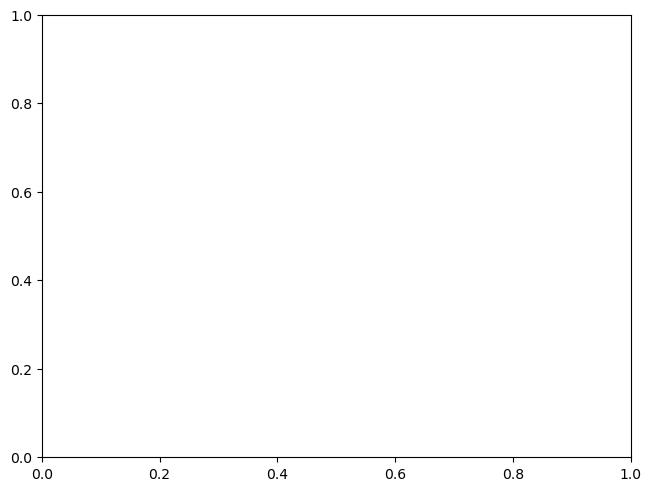

In [17]:
sdata.tables

sdata["RNA"].var.head()

#set index of var dataframe for the expression data
sdata.tables["RNA"].var.set_index("feature_name", inplace=True)

sdata["RNA"].var.head()

(
    sdata.pl.render_images()
    .pl.render_shapes(color="MALAT1")
    .pl.show()
)

# More Unfinish3d

But curious was the cell type data looks on this slice

Before: 228
After: 7
INFO     Rasterizing image for faster rendering.                                                                   


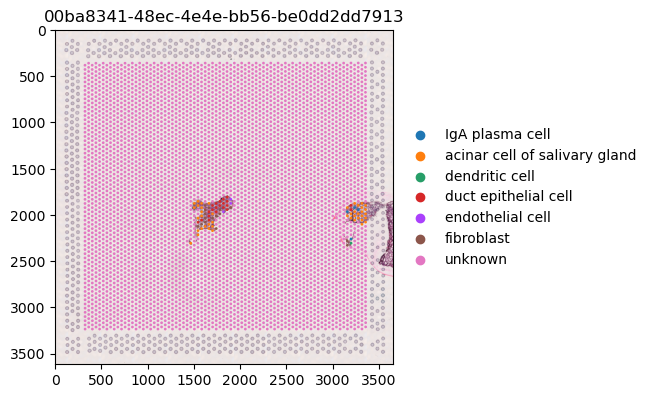

In [ ]:
# Print number of categories before resetting
print("Before:", len(sdata["RNA"].obs["cell_type"].cat.categories))

# Remove unused categories
sdata["RNA"].obs["cell_type"] = sdata["RNA"].obs["cell_type"].cat.remove_unused_categories()

# Print number of categories after resetting
print("After:", len(sdata["RNA"].obs["cell_type"].cat.categories))

(
    sdata.pl.render_images()
    .pl.render_shapes(color="cell_type")
    .pl.show()
)